# Real Time Semantic Segmentation with LightNet++

This notebook uses an open source project [LightNet++](https://github.com/ansleliu/LightNetPlusPlus) to segment cars, streets etc. in YouTube videos.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install LightNet++

In [0]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/ansleliu/LightNetPlusPlus.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q --depth 1 {git_repo_url}
  !pip install -q youtube-dl ninja
  
  # install NVidia/apex
  !git clone -q --depth 1 https://github.com/NVIDIA/apex.git
  !cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
  
import sys
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from IPython.display import YouTubeVideo

import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)


import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.nn as nn

from modules.inplace_abn.iabn import InPlaceABNSync
from functools import partial

from apex.fp16_utils import *
from apex import amp
import apex

cudnn.benchmark = True
assert torch.backends.cudnn.enabled, "fp16 mode requires cudnn backend to be enabled."
amp_handle = amp.init(enabled=True)

from models.shufflenetv2plus import ShuffleNetV2Plus

## Initialize LightNet++ (ShuffleNet based) 

In [0]:
# initialize model
model = ShuffleNetV2Plus(num_classes=19, fuse_chns=512, aspp_chns=256, aspp_dilate=(12, 24, 36), width_multi=1.0,
                             norm_act=partial(InPlaceABNSync, activation="leaky_relu", slope=0.01))
model = apex.parallel.convert_syncbn_model(model)
model = nn.DataParallel(model, device_ids=[0]).cuda()
pre_weight = torch.load(join(project_name, 'checkpoint/deepdrive_shufflenetv2plus_x1.0.pkl'))
pre_weight = pre_weight['model_state']
model.load_state_dict(pre_weight)
del pre_weight
model = model.eval()


# utils copied from https://github.com/ansleliu/LightNetPlusPlus/blob/master/deploy/cityscapes/video_demo/video_demo.py
def decode_segmap(pred, label_colours, num_classes):
    r = pred.copy()
    g = pred.copy()
    b = pred.copy()
    for l in range(0, num_classes):
        r[pred == l] = label_colours[l][0]
        g[pred == l] = label_colours[l][1]
        b[pred == l] = label_colours[l][2]

    rgb = np.zeros((pred.shape[0], pred.shape[1], 3))
    rgb[:, :, 0] = r
    rgb[:, :, 1] = g
    rgb[:, :, 2] = b
    return rgb
  
colors = [  # [  0,   0,   0],
          [128, 64, 128],
          [244, 35, 232],
          [70, 70, 70],
          [102, 102, 156],
          [190, 153, 153],
          [153, 153, 153],
          [250, 170, 30],
          [220, 220, 0],
          [107, 142, 35],
          [152, 251, 152],
          [0, 130, 180],
          [220, 20, 60],
          [255, 0, 0],
          [0, 0, 142],
          [0, 0, 70],
          [0, 60, 100],
          [0, 80, 100],
          [0, 0, 230],
          [119, 11, 32]]

label_colours = dict(zip(range(19), colors))
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence',
               'pole', 'traffic_light', 'traffic_sign', 'vegetation', 'terrain',
               'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train',
               'motorcycle', 'bicycle']

net_h, net_w, color_bar_w = 720, 1280, 120
frame_size = (net_w + color_bar_w, net_h)

color_map = label_colours
num_classes = 19

grid_height = int(net_h // num_classes)
start_pixel = int((net_h % num_classes) / 2)

color_bar = np.ones((net_h, color_bar_w, 3), dtype=np.uint8) * 128
for train_id in np.arange(num_classes):
    end_pixel = start_pixel + grid_height
    color_bar[start_pixel:end_pixel, :, :] = color_map[train_id]

    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(color_bar, class_names[train_id + 1],
                (2, start_pixel + 5 + int(grid_height // 2)),
                font, 0.55, (255, 255, 255), 1, cv2.LINE_AA)

    start_pixel = end_pixel
color_bar = color_bar[:, :, ::-1]

mean = [0.2997, 0.3402, 0.3072]
std = [0.1549, 0.1579, 0.1552]
trans_norm = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

## Segment an YouTube video with LightNet++

We are going to make semantic segmentions on the following youtube video:

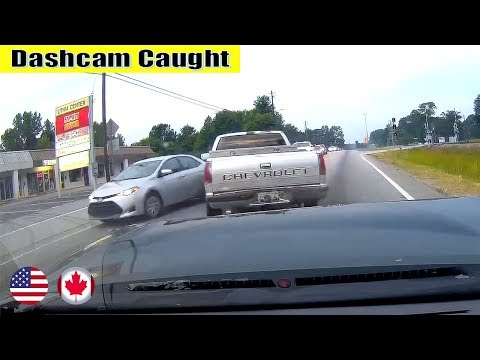

In [3]:
YOUTUBE_ID = 't4cN3JKf0hE'


YouTubeVideo(YOUTUBE_ID)

Download the above youtube video and segment the first 300 frames:

In [4]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v={YOUTUBE_ID}

[youtube] t4cN3JKf0hE: Downloading webpage
[youtube] t4cN3JKf0hE: Downloading video info webpage
[download] Destination: youtube.mp4
[download] 100% of 185.34MiB in 00:04


In [0]:
f = 0
video_capture = cv2.VideoCapture()
if video_capture.open('youtube.mp4'):
  width, height = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = video_capture.get(cv2.CAP_PROP_FPS)
  
  !rm -f output.mp4 output.avi
  # can't write out mp4, so try to write into an AVI file
  video_writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, frame_size)
  
  while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
      break
    frame = cv2.resize(frame, (net_w, net_h))
      
    image = trans_norm(frame)
    image = torch.unsqueeze(image, dim=0).cuda()  # [N, C, H, W]
    start_time = time.time()
    prediction = F.softmax(model(image), dim=1).argmax(dim=1)
    print("> Inference Time: {}s".format(time.time() - start_time))
    
    prediction = np.squeeze(prediction.cpu().numpy())
    prediction = decode_segmap(prediction, label_colours, num_classes)
    prediction = prediction.astype(np.uint8)
    
    img_msk = cv2.addWeighted(frame[:, :, ::-1], 0.55, prediction, 0.45, 0)
    img_msk = img_msk[:, :, ::-1]
    img_msk_color = np.concatenate((img_msk, color_bar), axis=1)
    video_writer.write(img_msk_color)
  
    f += 1
    # only on first 300 frames
    if f > 300:
      break
      
  video_capture.release()
  video_writer.release()
  
  # convert AVI to MP4
  !ffmpeg -y -loglevel info -i output.avi output.mp4
else:
  print("can't open the given input video file!")

Finally, visualize the result:

In [0]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)